In [20]:
!pip install apafib --upgrade  --quiet
!pip install pmlb --upgrade  --quiet

In [21]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

# **Problema individual: Spam vs Ham**
El spam es un problema generalizado en las redes sociales y las aplicaciones de mensajería. El interés para las compañías que gestionan estas redes y aplicaciones es el poder detectar lo antes posible cuando se empiezan a enviar estos mensajes para evitar el coste de su procesado y el que lleguen a los usuarios. El conjunto de datos SMS Spam Collection es un corpus de diferentes
colecciones de mensajes SMS legítimos y no deseados.

### Análisis exploratorio de los datos

Siempre es una buena idea hacer una pequeña exploración de los datos. Los datos reales necesitan procesamiento previo y es importante comprender su conjunto de datos para poder tomar buenas decisiones de diseño.

Vamos a hacer una visualización rápida de los datos. En esta visualización no usaremos histogramas para mostrar la distribución de las variables debido a que tenemos un conjunto de datos el cual contiene dos variables, la target value y la variable con el texto.

In [22]:
from apafib import load_sms_spam
df_spam = load_sms_spam()

print(df_spam[:10])

      0                                                  1
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...


Miramos si hay alguna instancia que no tenga texto, es decir que sea nulo, para descaratarla del análisis ya que no nos aportaria ninguna información para mas adelante

In [23]:
df_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5572 non-null   object
 1   1       5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Nombramiento de columnas para facilitar el trabajo con ellas

In [24]:
df_spam.columns = ['target', 'text']
df_spam.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Procedemos ahora a visualizar si hay un desbalanceo de clases, cosa que como sabemmos, puede afectar significativamente a las predicciones que nuestros modelos sean capaces de hacer

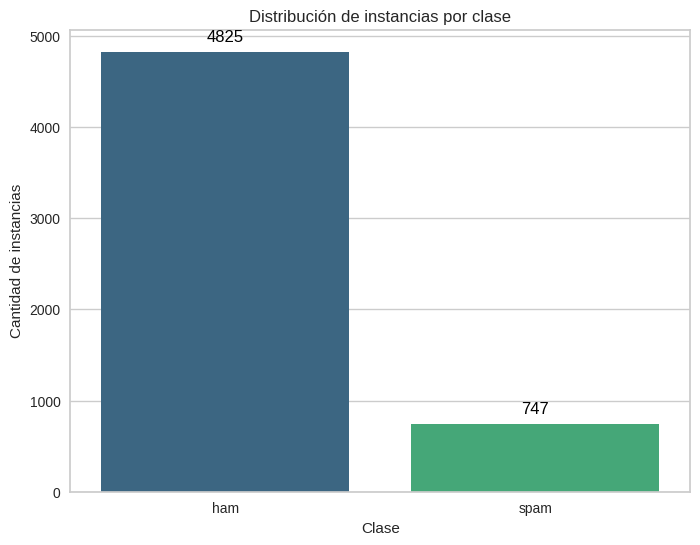

In [25]:
class_counts = df_spam['target'].value_counts()

plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=12, color='black',
                      xytext=(0, 5),
                      textcoords='offset points')

plt.xlabel("Clase")
plt.ylabel("Cantidad de instancias")
plt.title("Distribución de instancias por clase")
plt.show();

Como vemos, se observa tenemos un desbalanceo bastante grande, en nuestros datos, mas o menos de cada 8 mensajes tan solo uno es spam, cosa que podrá complicar luego a los modelos la clasificación en spam o no spam, debido a la falta de información de mensajes que realmente sean spam.

## Apartado A
Creamos los 4 Vectorizadores para las 4 configuraciones y transformamos los datos con dichas configuraciones

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vect_100_binary = CountVectorizer(max_features=100, binary=True, stop_words='english')
vect_100_count = CountVectorizer(max_features=100, binary=False, stop_words='english')
vect_250_binary = CountVectorizer(max_features=250, binary=True, stop_words='english')
vect_250_count = CountVectorizer(max_features=250, binary=False, stop_words='english')

X_100_binary = vect_100_binary.fit_transform(df_spam['text'])
X_100_count = vect_100_count.fit_transform(df_spam['text'])
X_250_binary = vect_250_binary.fit_transform(df_spam['text'])
X_250_count = vect_250_count.fit_transform(df_spam['text'])

Creamos los conjuntos de datos con las columnas generadas por cada Vectorizador

In [27]:
df_100_binary = pd.DataFrame(X_100_binary.toarray(), columns=vect_100_binary.get_feature_names_out())
df_100_binary['target'] = df_spam['target']

df_100_count = pd.DataFrame(X_100_count.toarray(), columns=vect_100_count.get_feature_names_out())
df_100_count['target'] = df_spam['target']

df_250_binary = pd.DataFrame(X_250_binary.toarray(), columns=vect_250_binary.get_feature_names_out())
df_250_binary['target'] = df_spam['target']

df_250_count = pd.DataFrame(X_250_count.toarray(), columns=vect_250_count.get_feature_names_out())
df_250_count['target'] = df_spam['target']

Comprobacion de que los Vectorizadores han hecho su trabajo como esperamos

In [28]:
print("Numero de columnas 100_binary: ", len(df_100_binary.columns)-1, "\n")
print("Numero de columnas 100_count: ", len(df_100_count.columns)-1, "\n")
print("Numero de columnas 250_binary: ", len(df_250_binary.columns)-1, "\n")
print("Numero de columnas 250_count: ", len(df_250_count.columns)-1, "\n")

Numero de columnas 100_binary:  100 

Numero de columnas 100_count:  100 

Numero de columnas 250_binary:  250 

Numero de columnas 250_count:  250 



Mostramos a continuacion unas cuantas palabras que representaran nuestras features en los conjuntos

In [29]:
print("Primeras 20 columnas 100_binary: \n", df_100_binary.columns[:20], "\n")

Primeras 20 columnas 100_binary: 
 Index(['150p', '50', 'amp', 'ask', 'babe', 'buy', 'care', 'cash', 'claim',
       'com', 'come', 'contact', 'cos', 'customer', 'da', 'day', 'dear', 'did',
       'doing', 'don'],
      dtype='object') 



No mostramos la matriz de correlación ni un análisis de la distribución que siguen las columnas con la target value dado que tenemos un número demasiado grande de variables que nos haria el análisis muy denso e incluso poco informativo por el tipo de datos que tenemos (Multinominal y Binario).

### Dividir en conjunto de entrenamiento y test
Generamos las particiones de entrenamiento de de test (80 %/20 %) estratificadas para cada conjunto de datos



In [30]:
def stratified_split(data, target_column, test_size=0.2, random_state=42):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        stratify=y,
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train_100_B, X_test_100_B, y_train_100_B, y_test_100_B = stratified_split(df_100_binary, 'target')
X_train_100_C, X_test_100_C, y_train_100_C, y_test_100_C = stratified_split(df_100_count, 'target')
X_train_250_B, X_test_250_B, y_train_250_B, y_test_250_B = stratified_split(df_250_binary, 'target')
X_train_250_C, X_test_250_C, y_train_250_C, y_test_250_C = stratified_split(df_250_count, 'target')


Procedemos ahora a aplicar PCA a cada conjunto

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Estandarizar los datos
scaler = StandardScaler()

X_train_100_B_scaled = scaler.fit_transform(X_train_100_B)
X_test_100_B_scaled = scaler.transform(X_test_100_B)

X_train_100_C_scaled = scaler.fit_transform(X_train_100_C)
X_test_100_C_scaled = scaler.transform(X_test_100_C)

X_train_250_B_scaled = scaler.fit_transform(X_train_250_B)
X_test_250_B_scaled = scaler.transform(X_test_250_B)

X_train_250_C_scaled = scaler.fit_transform(X_train_250_C)
X_test_250_C_scaled = scaler.transform(X_test_250_C)

# Aplicar PCA
pca_100_B = PCA(n_components=2)
X_train_100_B_pca = pca_100_B.fit_transform(X_train_100_B_scaled)
X_test_100_B_pca = pca_100_B.transform(X_test_100_B_scaled)

pca_100_C = PCA(n_components=2)
X_train_100_C_pca = pca_100_C.fit_transform(X_train_100_C_scaled)
X_test_100_C_pca = pca_100_C.transform(X_test_100_C_scaled)

pca_250_B = PCA(n_components=2)
X_train_250_B_pca = pca_250_B.fit_transform(X_train_250_B_scaled)
X_test_250_B_pca = pca_250_B.transform(X_test_250_B_scaled)

pca_250_C = PCA(n_components=2)
X_train_250_C_pca = pca_250_C.fit_transform(X_train_250_C_scaled)
X_test_250_C_pca = pca_250_C.transform(X_test_250_C_scaled)

print("PCA 100 Binary: ", pca_100_B.explained_variance_ratio_ * 100)
print("PCA 100 Count: ", pca_100_C.explained_variance_ratio_ * 100)
print("PCA 250 Binary: ", pca_250_B.explained_variance_ratio_ * 100)
print("PCA 250 Count: ", pca_250_C.explained_variance_ratio_ * 100)


PCA 100 Binary:  [3.01373052 2.42242526]
PCA 100 Count:  [2.99175394 2.36840873]
PCA 250 Binary:  [2.02318321 1.48422791]
PCA 250 Count:  [1.94650654 1.47133239]


Procedemos ahora a mostrar el gráfico de la varianza explicada y acomulada de las componentes

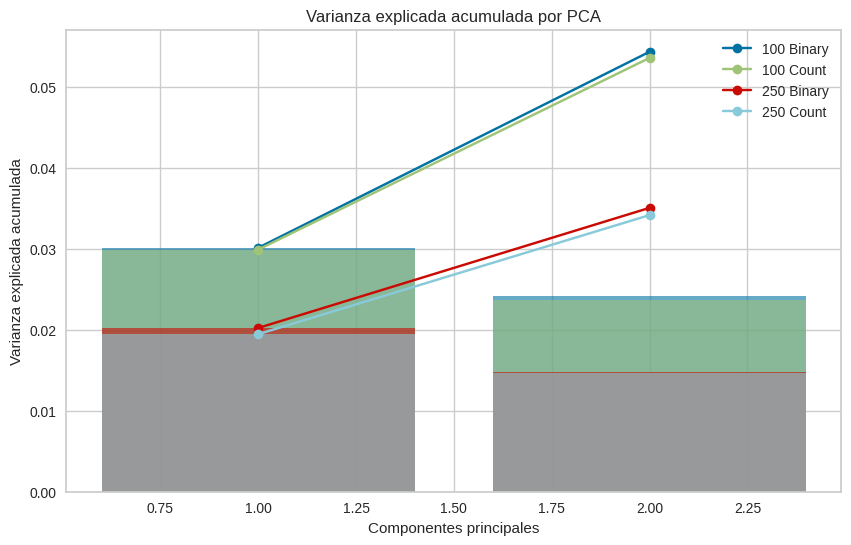

In [32]:
def plot_pca_variance(pca_100_B, pca_100_C, pca_250_B, pca_250_C):
    explained_variances = [
        pca_100_B.explained_variance_ratio_,
        pca_100_C.explained_variance_ratio_,
        pca_250_B.explained_variance_ratio_,
        pca_250_C.explained_variance_ratio_
    ]
    labels = ['100 Binary', '100 Count', '250 Binary', '250 Count']
    colors = ['b', 'g', 'r', 'c']

    plt.figure(figsize=(10, 6))

    for explained_variance, label, color in zip(explained_variances, labels, colors):
        plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', label=label, color=color)
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color=color)

    plt.xlabel('Componentes principales')
    plt.ylabel('Varianza explicada acumulada')
    plt.title('Varianza explicada acumulada por PCA')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pca_variance(pca_100_B, pca_100_C, pca_250_B, pca_250_C)

Vemos que en ambos modelos con menos variables obtienen mayor varianza explicada en las primeras compnentes como era de esperar ya que es mas facil extarer informacion de menos variables, aproximadamente las componentes de PCA con 100 variables explican un 50% mas de varianza que las de 250

Pasamos ahora a mostrar la representacion de los datos en 2D para ver si hay separabilidad suficiente

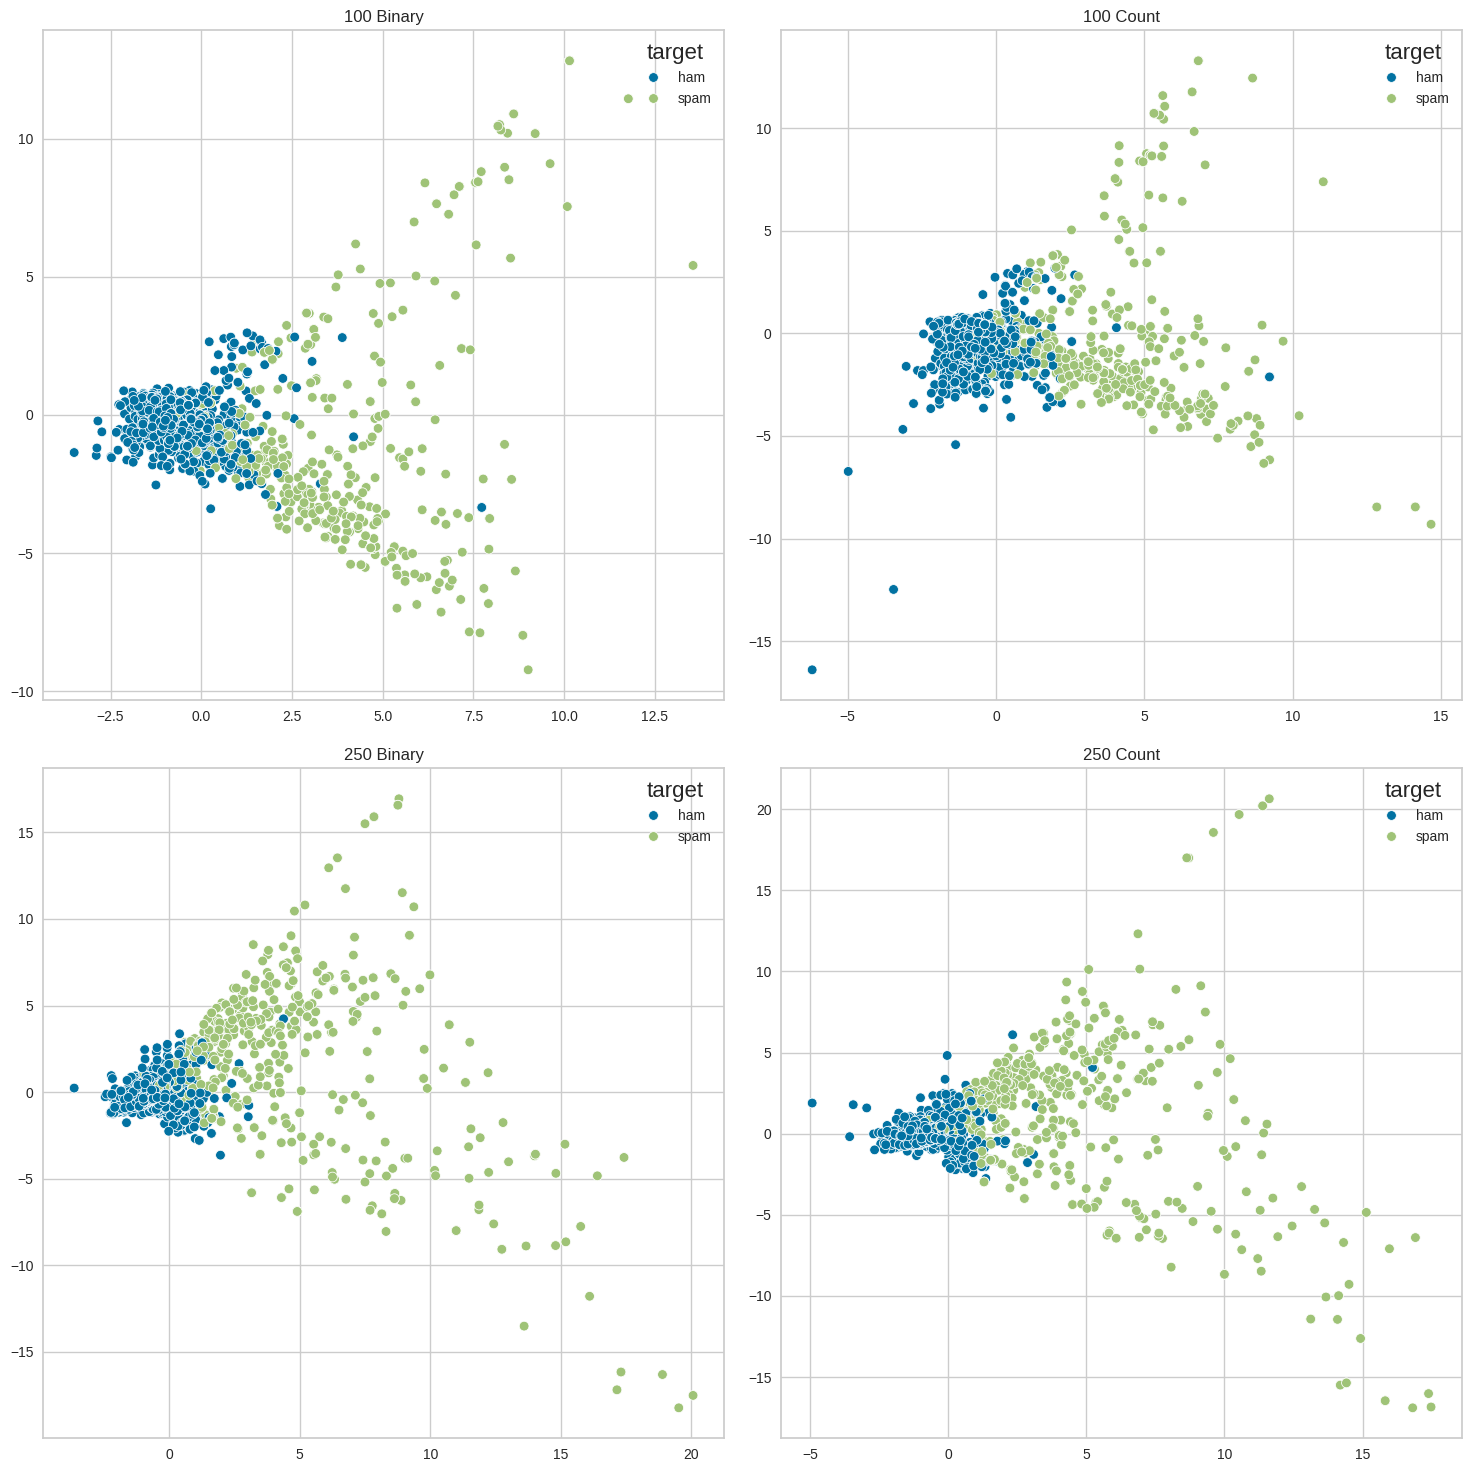

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

axes[0, 0].set_title('100 Binary')
sns.scatterplot(x=X_train_100_B_pca[:, 0], y=X_train_100_B_pca[:, 1], hue=y_train_100_B, ax=axes[0, 0])

axes[0, 1].set_title('100 Count')
sns.scatterplot(x=X_train_100_C_pca[:, 0], y=X_train_100_C_pca[:, 1], hue=y_train_100_C, ax=axes[0, 1])

axes[1, 0].set_title('250 Binary')
sns.scatterplot(x=X_train_250_B_pca[:, 0], y=X_train_250_B_pca[:, 1], hue=y_train_250_B, ax=axes[1, 0])

axes[1, 1].set_title('250 Count')
sns.scatterplot(x=X_train_250_C_pca[:, 0], y=X_train_250_C_pca[:, 1], hue=y_train_250_C, ax=axes[1, 1])

plt.tight_layout()
plt.show();

Vemos ahora por otra parte que la separabilidad de los datos con mas variables parece obtener mejores resultados que las que tienen menos variables y se podria intentar separar una frontera obteniendo resultados mas acertados.

Sin embargo, seguimos sin poder considerar que la separabilidad de los datos es aceptable dado que vemos que como mas cerca del valor 0 en el eje X mas agrupadas se encuentran las instancias y cuanto mas se alejen del 0, mas dispersas se ecuentran, tanto hacia arriba del eje Y como hacia abajo.

Y por otra parte, tanto con Binarias como como con Multinominales características vemos que la representación 2 dimensional es casi la misma.

## Apartado B
Tenemos datos que o son binarios (Bernoulli) o corresponden a distribuciones multinomiales respectivamente. Si asumimos que las palabras de un texto son independientes (no lo son realmente) podemos usar Naïve Bayes para clasificarlos. Tienes en scikit-learn modelos de Naïve Bayes que usan estas dos distribuciones. Aplica estos métodos a los conjuntos de datos que has generado y determina la calidad de los modelos (la calidad no se limita solo al acierto). Comenta los resultados.

### Save results

In [34]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

### Naïve Bayes Bernoulli

Procedemos a aplicar a los conjuntos binarios un modelo de Naïve Bayes con distribución Bernoulli

In [35]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

nb_100_B = BernoulliNB()
nb_100_B.fit(X_train_100_B, y_train_100_B)
y_pred_100_B = nb_100_B.predict(X_test_100_B)

print("Classification Report for 100 Binary features:\n", classification_report(y_test_100_B, y_pred_100_B))

nb_250_B = BernoulliNB()
nb_250_B.fit(X_train_250_B, y_train_250_B)
y_pred_250_B = nb_250_B.predict(X_test_250_B)

print("Classification Report for 250 Binary features:\n", classification_report(y_test_250_B, y_pred_250_B))

results_df = save_results(nb_100_B, X_test_100_B, y_test_100_B, 'Naive Bayes 100 Binary', results_df)
results_df = save_results(nb_250_B, X_test_250_B, y_test_250_B, 'Naive Bayes 250 Binary', results_df)

Classification Report for 100 Binary features:
               precision    recall  f1-score   support

         ham       0.96      0.99      0.98       966
        spam       0.95      0.76      0.84       149

    accuracy                           0.96      1115
   macro avg       0.96      0.88      0.91      1115
weighted avg       0.96      0.96      0.96      1115

Classification Report for 250 Binary features:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



Vemos como ambos resultados obtienen unos resultados muy buenos si tenemos en cuenta las metricas de accuracy.

Si queremos rizar el rizo podemos ver que por otra parte las metricas de recall en ambos modelos no son tan buenas en la clase minoritaria de spam,
por lo tanto esdeviene en obtener peores resultados tambien en la métrica f1.

Cuando nos encontramos en un caso como este ya vemos que el causante de recuperar datos de una clase es debido a la falta de instancias de dicha clase, tenemos un 80% menos de datos de la clase minoritaria como hemos visto previamente.

Mostramos tambien a continuacion las matrices de confusion de ambos conjuntos

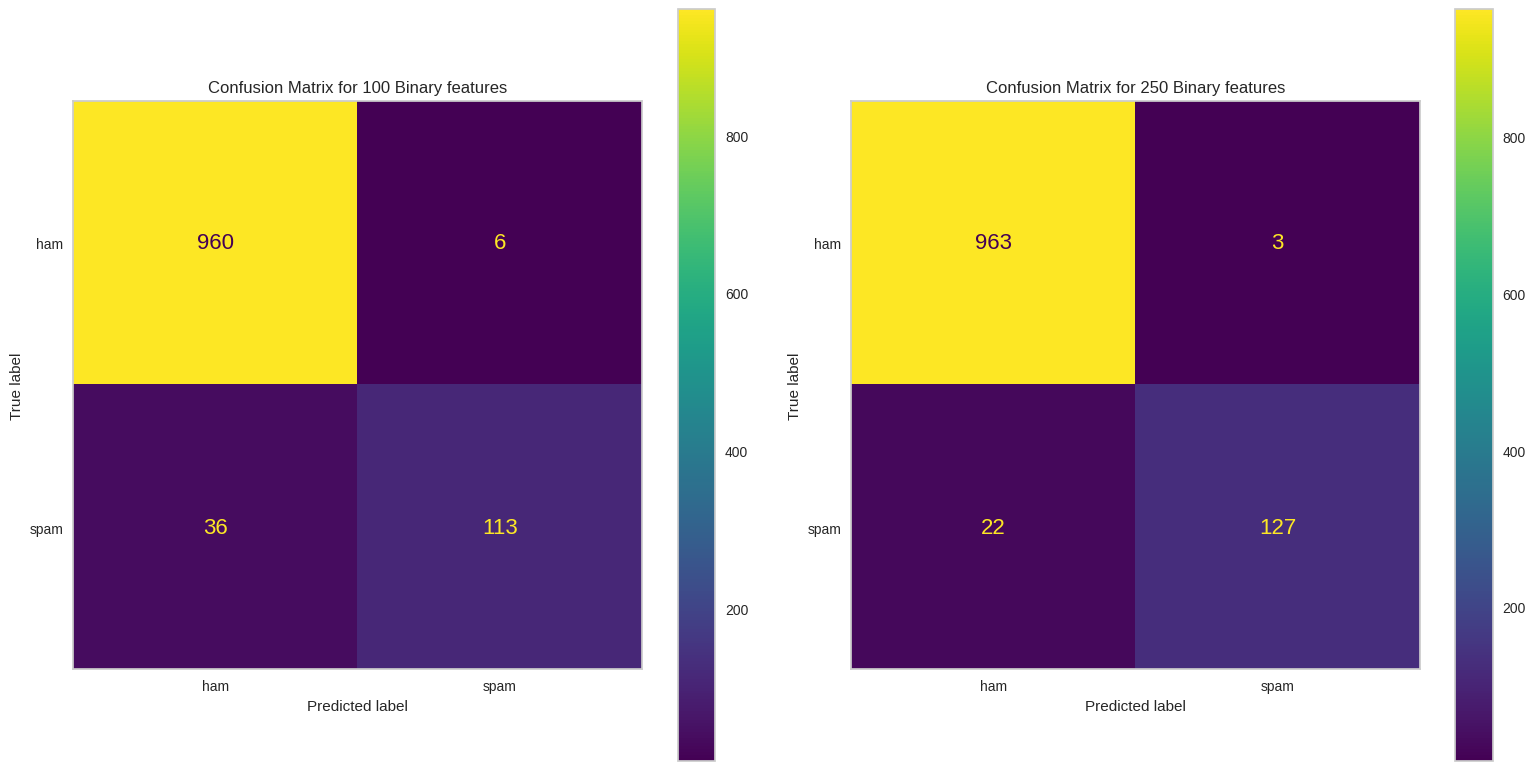

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].grid(False)
axes[1].grid(False)

ConfusionMatrixDisplay.from_estimator(nb_100_B, X_test_100_B, y_test_100_B, ax=axes[0])
axes[0].set_title('Confusion Matrix for 100 Binary features')

ConfusionMatrixDisplay.from_estimator(nb_250_B, X_test_250_B, y_test_250_B, ax=axes[1])
axes[1].set_title('Confusion Matrix for 250 Binary features')

plt.tight_layout()
plt.show();


Vemos como hechando un vistazo a las matrizes de confusion de ambos modelos aun observamos con mayor claridad los resultados del clasification report comentados arriba

Mostramos a continuación la curva ROC para ambos modelos

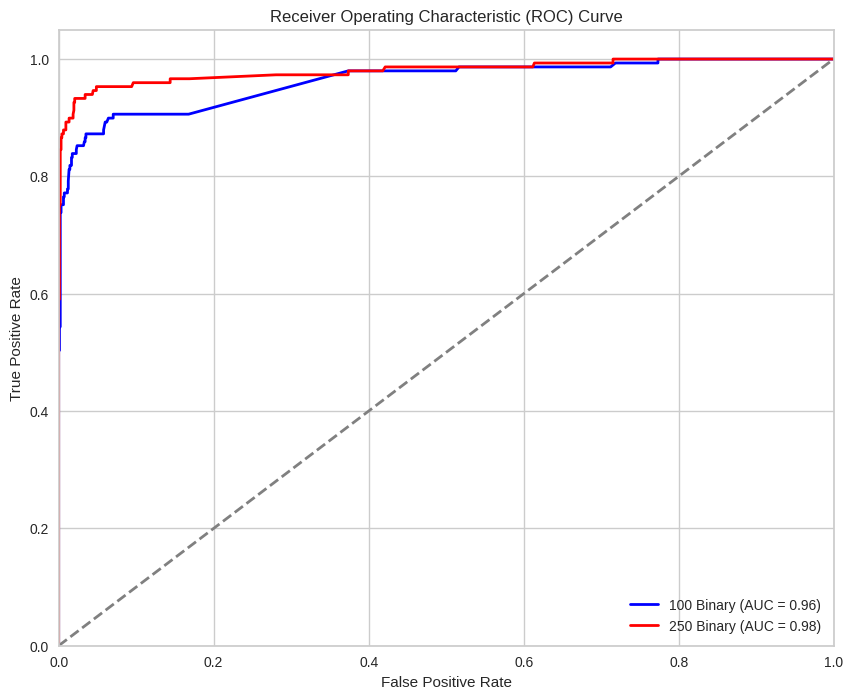

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

fpr_100_B, tpr_100_B, _ = roc_curve(y_test_100_B, nb_100_B.predict_proba(X_test_100_B)[:, 1], pos_label='spam')
roc_auc_100_B = roc_auc_score(y_test_100_B, nb_100_B.predict_proba(X_test_100_B)[:, 1])

fpr_250_B, tpr_250_B, _ = roc_curve(y_test_250_B, nb_250_B.predict_proba(X_test_250_B)[:, 1], pos_label='spam')
roc_auc_250_B = roc_auc_score(y_test_250_B, nb_250_B.predict_proba(X_test_250_B)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_100_B, tpr_100_B, color='blue', lw=2, label=f'100 Binary (AUC = {roc_auc_100_B:.2f})')
plt.plot(fpr_250_B, tpr_250_B, color='red', lw=2, label=f'250 Binary (AUC = {roc_auc_250_B:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

Vemos si observamos la curva de ROC que realmente el modelo con mas variables funciona mejor, alcanzamos un ratio de verdaderos positivos mas alto con un ratio de falsos positvos mas bajo

### Naive Bayes Multinominal

Procedemos ahora a aplica a las dos classes con valores multinominales un Naive Bayes con distribuicon Multinominal

In [38]:
nb_100_C = MultinomialNB()
nb_100_C.fit(X_train_100_C, y_train_100_C)
y_pred_100_C = nb_100_C.predict(X_test_100_C)
print("Classification Report for 100 Count features:\n", classification_report(y_test_100_C, y_pred_100_C))

nb_250_C = MultinomialNB()
nb_250_C.fit(X_train_250_C, y_train_250_C)
y_pred_250_C = nb_250_C.predict(X_test_250_C)
print("Classification Report for 250 Count features:\n", classification_report(y_test_250_C, y_pred_250_C))

results_df = save_results(nb_100_C, X_test_100_C, y_test_100_C, 'Naive Bayes 100 Count', results_df)
results_df = save_results(nb_250_C, X_test_250_C, y_test_250_C, 'Naive Bayes 250 Count', results_df)

Classification Report for 100 Count features:
               precision    recall  f1-score   support

         ham       0.97      0.99      0.98       966
        spam       0.92      0.79      0.85       149

    accuracy                           0.96      1115
   macro avg       0.95      0.89      0.92      1115
weighted avg       0.96      0.96      0.96      1115

Classification Report for 250 Count features:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.98       966
        spam       0.91      0.90      0.90       149

    accuracy                           0.97      1115
   macro avg       0.94      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115



Vemos como en estos dos conjuntos no obtenemos una precision tan alta en la clase minoritaria.

Sin embargo, observamos un incremento considerable en la recuperación de ambos conjuntos, en especial en el de las 250 variables, lo que comporta tambien a un mejore resultado en la métrica f1.

Mostramos tambien a continuacion las matrices de confusion de ambos conjuntos

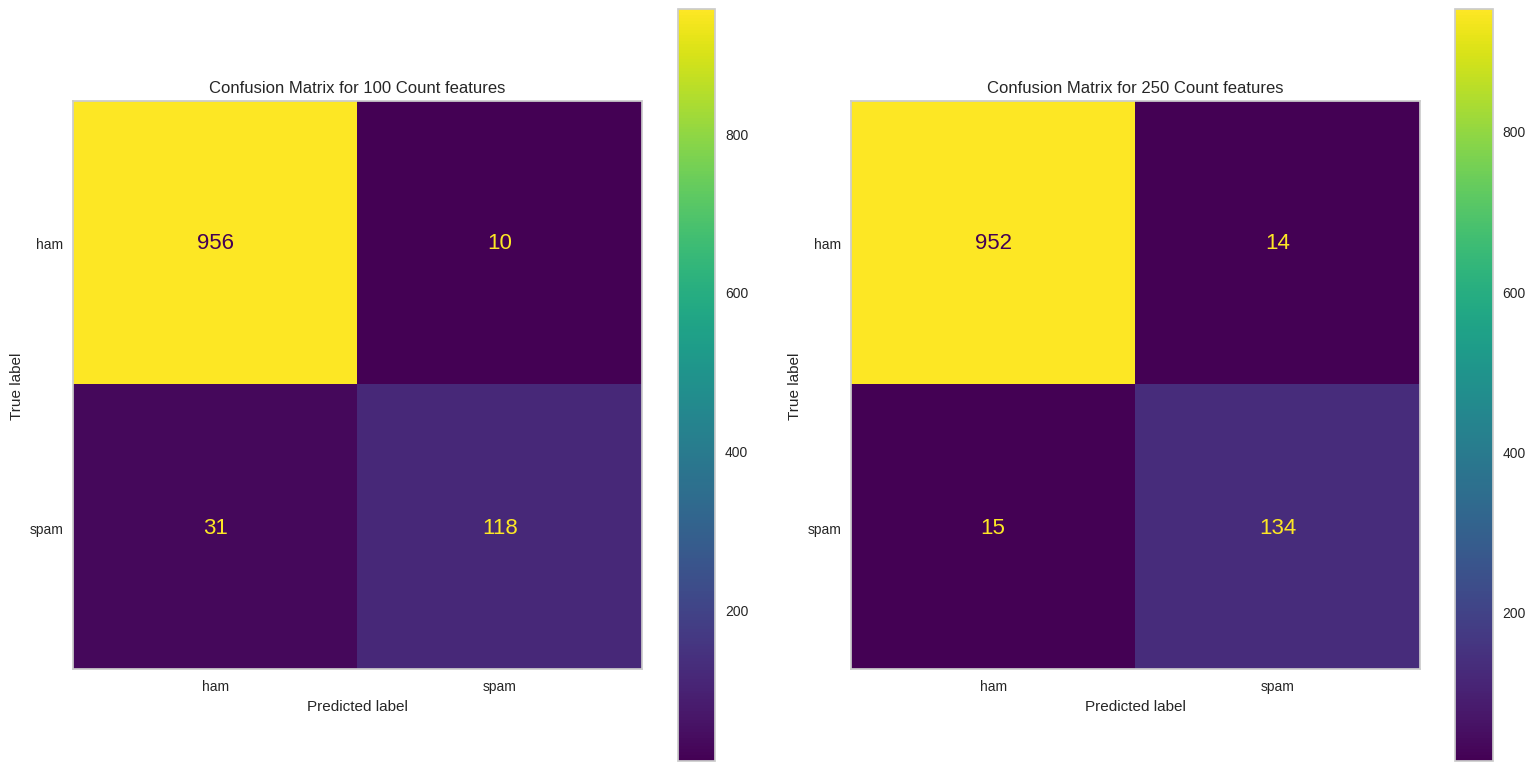

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].grid(False)
axes[1].grid(False)

ConfusionMatrixDisplay.from_estimator(nb_100_C, X_test_100_C, y_test_100_C, ax=axes[0])
axes[0].set_title('Confusion Matrix for 100 Count features')

ConfusionMatrixDisplay.from_estimator(nb_250_C, X_test_250_C, y_test_250_C, ax=axes[1])
axes[1].set_title('Confusion Matrix for 250 Count features')

plt.tight_layout()
plt.show();

Vemos con ambas matrices que claramente ahora recuperamos 5 y 7 valores de la clase minoritaria sacrificando 6 y 11 valores, respectivamente, de la clase mayoritaria, lo que justifica el aumento de la métrica recall

Mostramos a continuación la curva ROC para ambos modelos

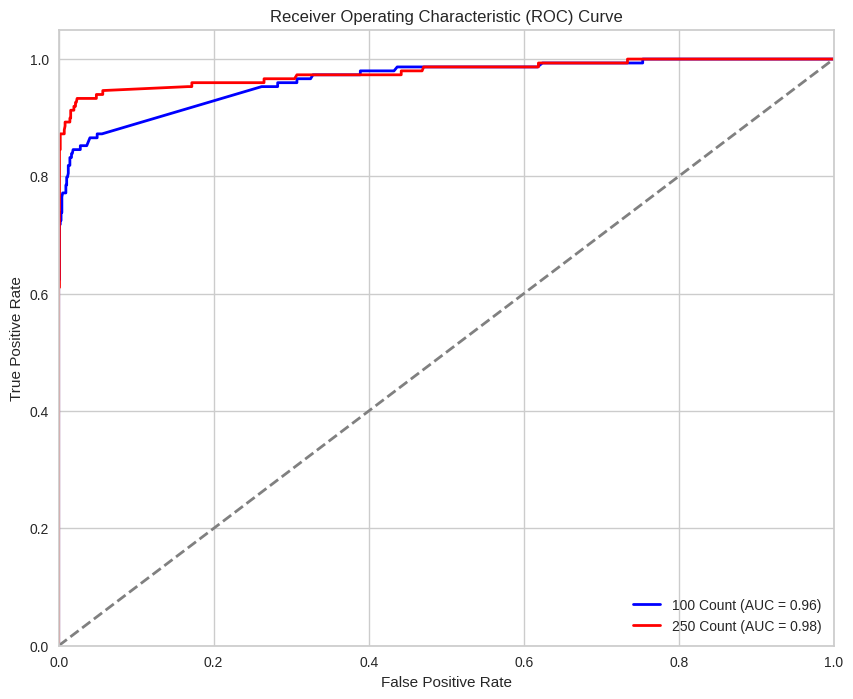

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

fpr_100_C, tpr_100_C, _ = roc_curve(y_test_100_C, nb_100_C.predict_proba(X_test_100_C)[:, 1], pos_label='spam')
roc_auc_100_C = roc_auc_score(y_test_100_C, nb_100_C.predict_proba(X_test_100_C)[:, 1])

fpr_250_C, tpr_250_C, _ = roc_curve(y_test_250_C, nb_250_C.predict_proba(X_test_250_C)[:, 1], pos_label='spam')
roc_auc_250_C = roc_auc_score(y_test_250_C, nb_250_C.predict_proba(X_test_250_C)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_100_C, tpr_100_C, color='blue', lw=2, label=f'100 Count (AUC = {roc_auc_100_C:.2f})')
plt.plot(fpr_250_C, tpr_250_C, color='red', lw=2, label=f'250 Count (AUC = {roc_auc_250_C:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

Vemos que el comportamiento es muy similar al anterior aunque observamos un ligero incremento de rendimiento en el conjunto con 100 columnas

## Apartado C

Los modelos generativos funcionan bien si la suposición que hacemos sobre la distribución
de los datos es correcta. Los modelos discriminativos como Regresión Logística pueden ser adecuados cuando no esta clara la distribución de los atributos. Ajusta un modelo de regresión logística a los conjuntos de datos que has generado explorando los hiperparámetros
del modelo y determina la calidad de los mejores modelos. Comenta los resultados.

### Regresión Logística
La regresión logística estima directamente  $p(y=C_k|X=x)$ evitando el tener que asumir una distribución específica para los atributos de las clases. La estimación corresponde a los ratios entre las probabilidades de las clases que se convierten en probabilidades a través de la función sigmoide. De esta manera:

$p(C|X) = \sigma(w\cdot x)$ 

Procedemos a aplicar una regresión logística a los distintos conjuntos de datos 

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(max_iter=10000, solver='liblinear')
param = {'penalty': ['l1', 'l2', ], 'C': 10**np.linspace(-3, 3, 51, endpoint=True)}

datasets = {
    '100_B': (X_train_100_B, y_train_100_B, X_test_100_B, y_test_100_B),
    '100_C': (X_train_100_C, y_train_100_C, X_test_100_C, y_test_100_C),
    '250_B': (X_train_250_B, y_train_250_B, X_test_250_B, y_test_250_B),
    '250_C': (X_train_250_C, y_train_250_C, X_test_250_C, y_test_250_C)
}

results = {}

for name, (X_train, y_train, X_test, y_test) in datasets.items():
    lr_gs = GridSearchCV(lr, param, cv=10, n_jobs=-1, refit=True, verbose=0)
    _ = lr_gs.fit(X_train, y_train);
    best_model = lr_gs.best_estimator_
    y_pred = best_model.predict(X_test)
    results[name] = {
        'best_params': lr_gs.best_params_,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'cv_results': lr_gs.cv_results_,
        'best_model': best_model
    }

for name, result in results.items():
    print(f"Results for {name}:")
    print(result['classification_report'])
    show_html(pd.DataFrame(result['cv_results']).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())
    results_df = save_results(result['best_model'], datasets[name][2], datasets[name][3], f'Logistic Regression {name}', results_df)
    print("\n")

Results for 100_B:
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       966
        spam       0.96      0.79      0.87       149

    accuracy                           0.97      1115
   macro avg       0.96      0.89      0.92      1115
weighted avg       0.97      0.97      0.97      1115



,params,mean_test_score,rank_test_score
69,"{'C': 12.02264434617413, 'penalty': 'l2'}",0.966,1
63,"{'C': 5.248074602497723, 'penalty': 'l2'}",0.965,2
73,"{'C': 20.892961308540407, 'penalty': 'l2'}",0.965,3
75,"{'C': 27.542287033381633, 'penalty': 'l2'}",0.965,3
71,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.965,5




Results for 100_C:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.97      0.79      0.87       149

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



,params,mean_test_score,rank_test_score
77,"{'C': 36.3078054770101, 'penalty': 'l2'}",0.965,1
97,"{'C': 575.4399373371566, 'penalty': 'l2'}",0.965,2
82,"{'C': 83.17637711026708, 'penalty': 'l1'}",0.965,2
84,"{'C': 109.64781961431851, 'penalty': 'l1'}",0.965,2
90,"{'C': 251.18864315095772, 'penalty': 'l1'}",0.965,2




Results for 250_B:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.95      0.85      0.90       149

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



,params,mean_test_score,rank_test_score
63,"{'C': 5.248074602497723, 'penalty': 'l2'}",0.977,1
65,"{'C': 6.918309709189363, 'penalty': 'l2'}",0.977,2
61,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.977,3
67,"{'C': 9.120108393559097, 'penalty': 'l2'}",0.977,4
59,"{'C': 3.019951720402016, 'penalty': 'l2'}",0.977,5




Results for 250_C:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.95      0.85      0.90       149

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



,params,mean_test_score,rank_test_score
61,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.978,1
59,"{'C': 3.019951720402016, 'penalty': 'l2'}",0.978,2
65,"{'C': 6.918309709189363, 'penalty': 'l2'}",0.978,3
67,"{'C': 9.120108393559097, 'penalty': 'l2'}",0.978,4
57,"{'C': 2.2908676527677723, 'penalty': 'l2'}",0.977,5


Podemos ver como el mejor resultado que obtenemos es el de 250 columnas con valores multinominales, muy cerca de los resultados del conjunto de 250 columnas binario.

Vemos como la regularización que mejores resultados obtiene en todos los modelos es la Ridge(L2) y vemos que los modelos con 100 variables no se quedan muy lejos de obtener los resultados de lso conjuntos con 250 variables.

Procedemos a continuación a mostrar los pesos de la regresión logística. Mostraremos solo los 10 con mayor peso y los 10 con menor peso dado que si mostramos todos los coeficientes la interpretabilidad nos seria muy complicada.

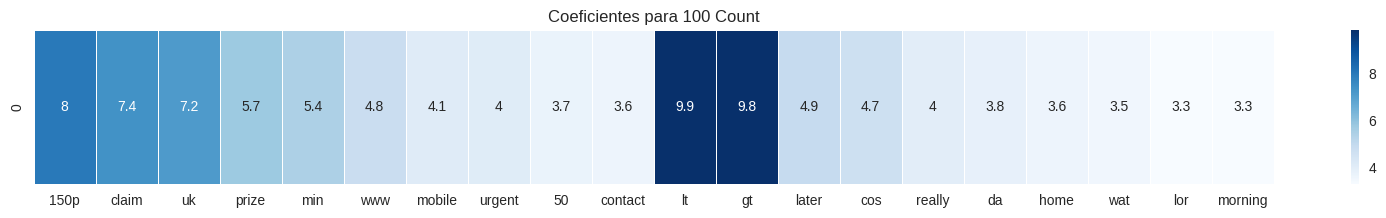

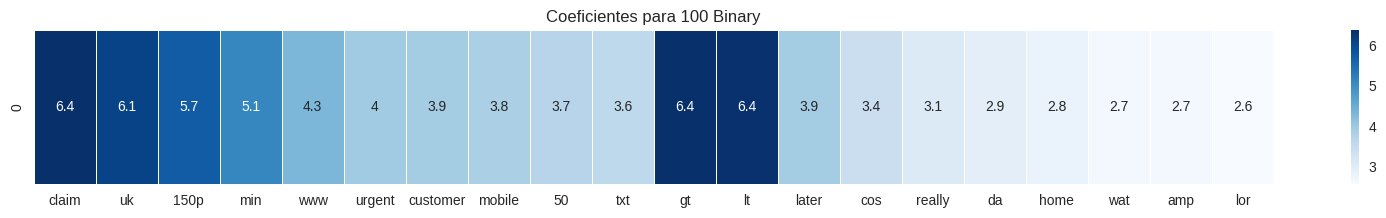

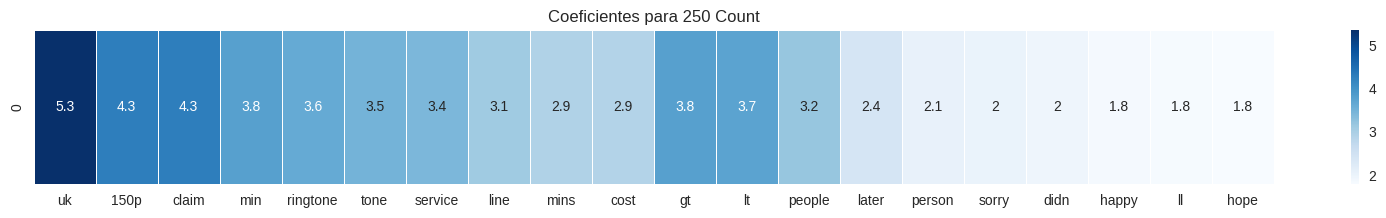

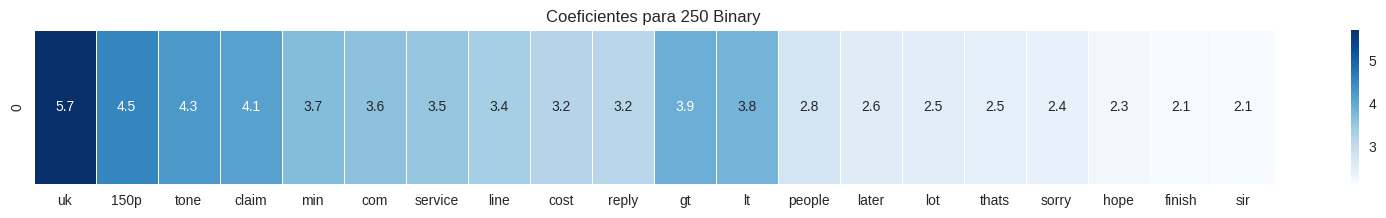

In [42]:
def plot_top_bottom_coefs(results, vectorizer, title):
    coefs = pd.DataFrame(results['best_model'].coef_, columns=vectorizer.get_feature_names_out())
    
    top_10_coefs = coefs.T.nlargest(10, 0)
    bottom_10_coefs = coefs.T.nsmallest(10, 0)
    
    selected_coefs = pd.concat([top_10_coefs, bottom_10_coefs])
    
    plt.figure(figsize=(20, 2))
    sns.heatmap(selected_coefs.T.abs(), annot=True, linewidths=.5, cbar=True, xticklabels=True, cmap='Blues', annot_kws={'size': 10})
    plt.title(title)
    plt.show()

plot_top_bottom_coefs(results['100_C'], vect_100_count, 'Coeficientes para 100 Count')

plot_top_bottom_coefs(results['100_B'], vect_100_binary, 'Coeficientes para 100 Binary')

plot_top_bottom_coefs(results['250_C'], vect_250_count, 'Coeficientes para 250 Count')

plot_top_bottom_coefs(results['250_B'], vect_250_binary, 'Coeficientes para 250 Binary')


Vemos como en general las palabras con mayores y menores pesos coinciden en todos los conjuntos, en especial entre los dos de 100 y los dos de 250.

Vemos como los mayores pesos para los dos conjuntos de 100 columnas son "lt" y "gt", en especial para el binario, y luego tenemos 3 palabras como "150p", "claim" y "uk" que tienen un peso un poco menor en el binario y en el conjunto multinominal tienen pesos muy parecidos a "lt" y "gt".

En los casos de 250 columnas vemos como las dos columnas "gt" y "lt" pierden importancia y la ganan las tres "150p", "claim" y "uk".

Procedemos ahora a mostrar el classification report para cada modelo

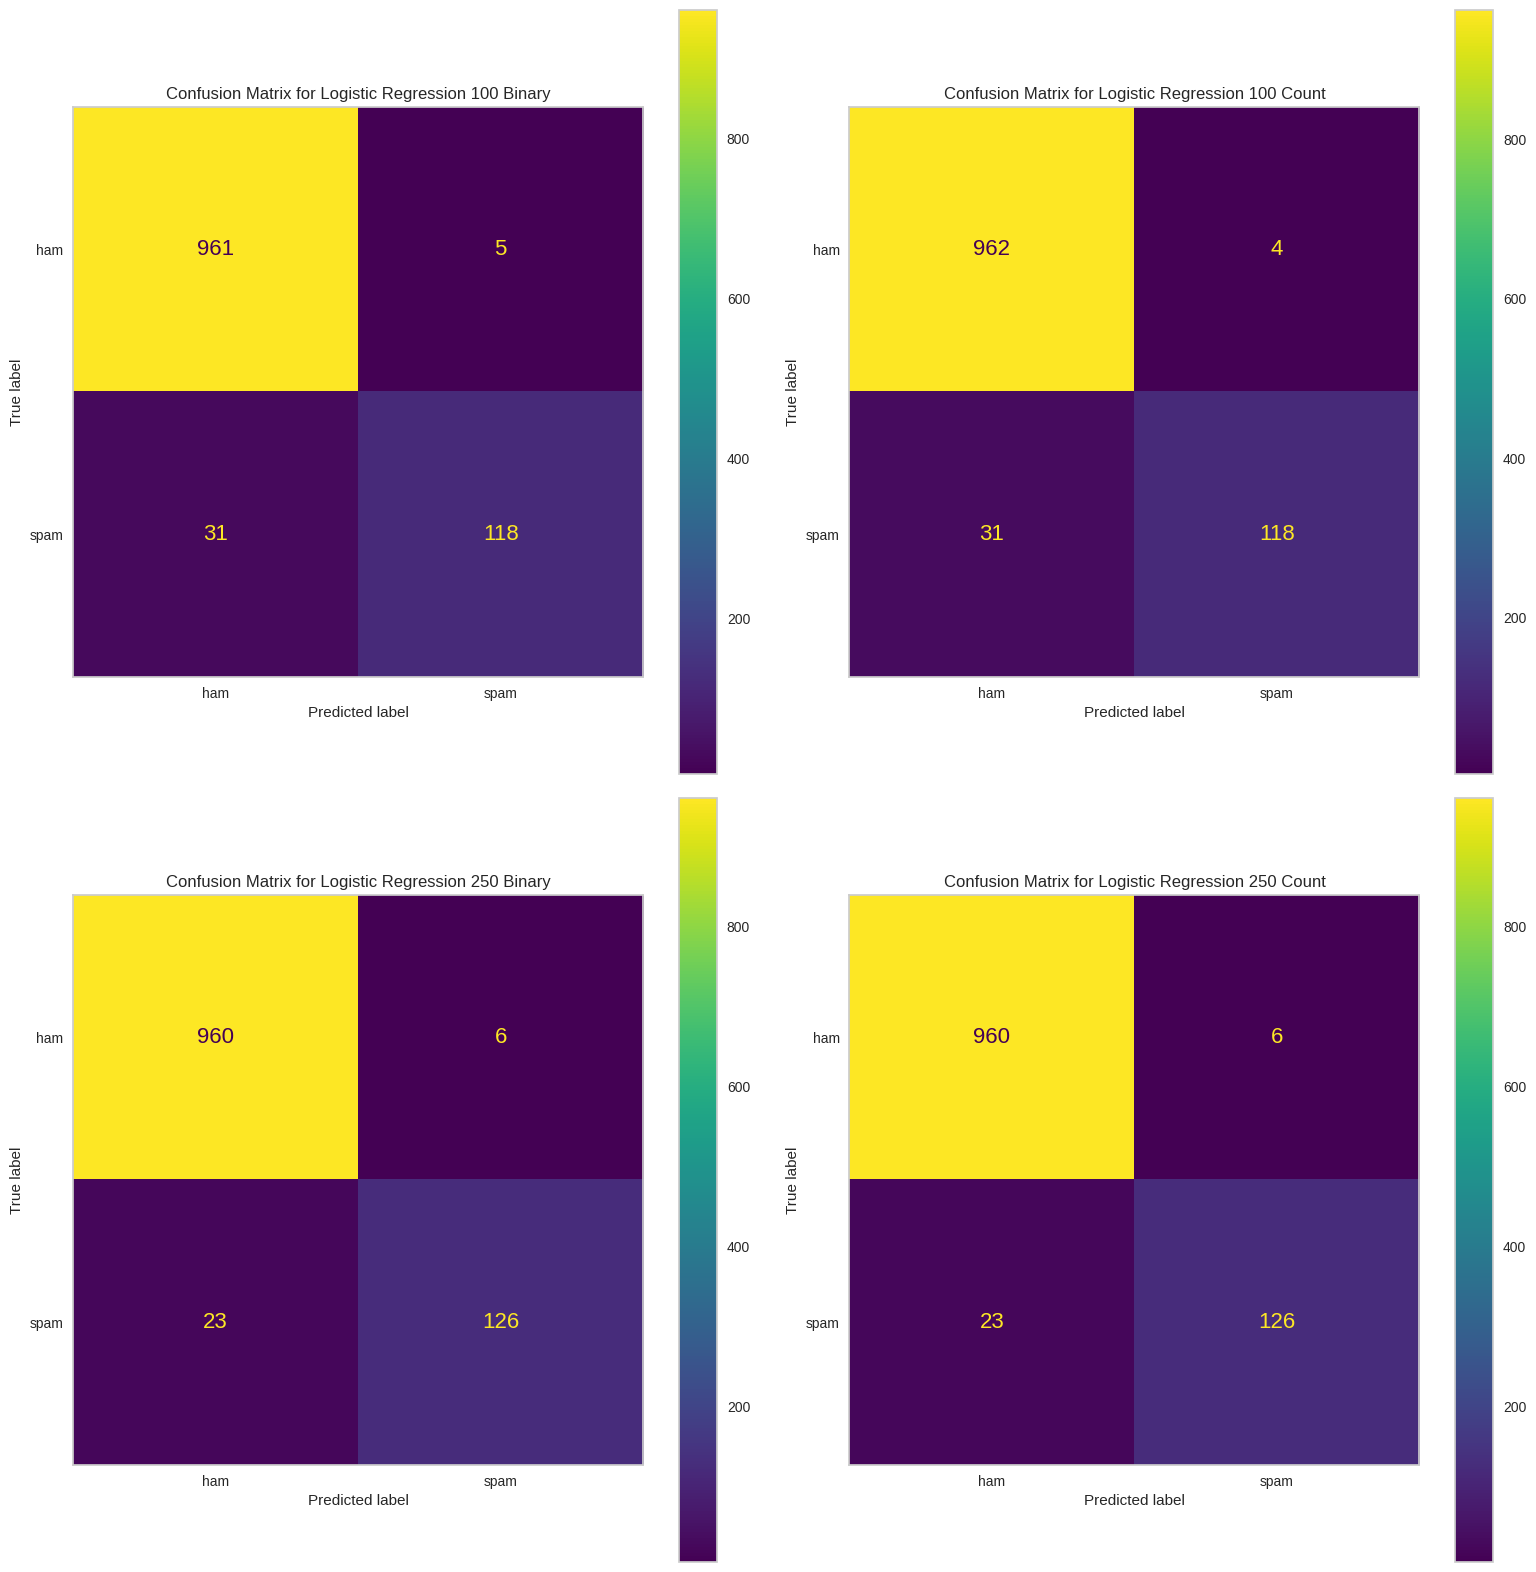

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].grid(False)
axes[0, 1].grid(False)
axes[1, 0].grid(False)
axes[1, 1].grid(False)

ConfusionMatrixDisplay.from_estimator(results['100_B']['best_model'], X_test_100_B, y_test_100_B, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix for Logistic Regression 100 Binary')

ConfusionMatrixDisplay.from_estimator(results['100_C']['best_model'], X_test_100_C, y_test_100_C, ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix for Logistic Regression 100 Count')

ConfusionMatrixDisplay.from_estimator(results['250_B']['best_model'], X_test_250_B, y_test_250_B, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix for Logistic Regression 250 Binary')

ConfusionMatrixDisplay.from_estimator(results['250_C']['best_model'], X_test_250_C, y_test_250_C, ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix for Logistic Regression 250 Count')

plt.tight_layout()
plt.show();

Observando las matrices de confusion y los clasification reports mostrados previamente que realmente en la regresión logísitica no afecta practicamente usar colmunas binarias o multinominales, obtenemos resultados pracitcamente idénticos y cuantas mas columnas mas datos de la clase minoritaria somos capaces de recuperar.

Si comparamos los resultados con los obtenidos al hacer Naive Bayes, vemos que realmente tanto el NB con Bernoulli como el NB con Multinominal para el conjunto de 250 variables, obtenian mejores resultados que los obtenidos con regresion logística. Dado que sacrificaban un poco de recall de la clase mayoritaria para obtener un mayor recall en la minoritaria que es realmente lo que nos importa en este problema.

In [44]:
results_df.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (M),recall score (M),f1 score (M)
Naive Bayes 250 Binary,0.978,0.977,0.925,0.949
Naive Bayes 250 Count,0.974,0.945,0.942,0.944
Logistic Regression 250_B,0.974,0.966,0.920,0.941
Logistic Regression 250_C,0.974,0.966,0.920,0.941
Logistic Regression 100_C,0.969,0.968,0.894,0.926
Logistic Regression 100_B,0.968,0.964,0.893,0.925
Naive Bayes 100 Count,0.963,0.945,0.891,0.915
Naive Bayes 100 Binary,0.962,0.957,0.876,0.911


## Apartado D

Probablemente, la frontera entre los SMS legítimos y los no deseados sea bastante compleja. Dado que tenemos bastantes datos, esto es algo que podría aprovechar k-vecinos cercanos. Ajusta adecuadamente los hiperparámetros de este modelo a los datos y determina la calidad de los mejores modelos. Comenta los resultados.
¿Qué modelo elegirías entre todos? Si nuestro objetivo fuera el poder determinar la clase
de un SMS de la manera más eficiente posible ¿qué modelo te parecería el mejor? No te
limites a escoger uno, piensa en todas las cosas que influyen en el coste de clasificar un
ejemplo.

### K-nearest neighbours

El modelo de vecinos cercanos asume que tenemos fronteras complejas entre las clases que se pueden aproximar de manera local. Este modelo se beneficia de que tengamos un conjunto de datos con muchos ejemplos. También funciona mejor si la escala que tiene cada atributo es la misma para no dar más importancia a una dimensión que a otra.

In [45]:
knn = KNeighborsClassifier()
param = {'n_neighbors': [1, 3, 5, 7, 11, 15, 17, 19, 21],
         'weights': ['distance', 'uniform'], 
         'metric': ['euclidean', 'manhattan', 'cosine']}

results_knn = {}

for name, (X_train, y_train, X_test, y_test) in datasets.items():
    knn_gs = GridSearchCV(knn, param, cv=10, n_jobs=-1, refit=True, verbose=0)
    _ = knn_gs.fit(X_train, y_train)
    best_knn_model = knn_gs.best_estimator_
    y_pred = best_knn_model.predict(X_test)
    results_knn[name] = {
        'best_params': knn_gs.best_params_,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'cv_results': knn_gs.cv_results_,
        'best_model': best_knn_model
    }

# Display the results
for name, result in results_knn.items():
    print(f"Results for {name}:")
    print(result['classification_report'])
    show_html(pd.DataFrame(result['cv_results']).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())
    results_df = save_results(result['best_model'], datasets[name][2], datasets[name][3], f'KNN {name}', results_df)
    print("\n")

Results for 100_B:
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       966
        spam       0.95      0.74      0.83       149

    accuracy                           0.96      1115
   macro avg       0.95      0.87      0.90      1115
weighted avg       0.96      0.96      0.96      1115



,params,mean_test_score,rank_test_score
42,"{'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}",0.969,1
40,"{'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}",0.968,2
44,"{'metric': 'cosine', 'n_neighbors': 11, 'weights': 'distance'}",0.966,3
38,"{'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}",0.965,4
46,"{'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}",0.965,5




Results for 100_C:
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       966
        spam       0.93      0.76      0.84       149

    accuracy                           0.96      1115
   macro avg       0.95      0.88      0.91      1115
weighted avg       0.96      0.96      0.96      1115



,params,mean_test_score,rank_test_score
40,"{'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}",0.966,1
42,"{'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}",0.966,2
38,"{'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}",0.964,3
44,"{'metric': 'cosine', 'n_neighbors': 11, 'weights': 'distance'}",0.963,4
46,"{'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}",0.962,5




Results for 250_B:
              precision    recall  f1-score   support

         ham       0.97      0.88      0.92       966
        spam       0.51      0.81      0.63       149

    accuracy                           0.87      1115
   macro avg       0.74      0.85      0.78      1115
weighted avg       0.91      0.87      0.88      1115



,params,mean_test_score,rank_test_score
38,"{'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}",0.976,1
40,"{'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}",0.975,2
42,"{'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}",0.974,3
39,"{'metric': 'cosine', 'n_neighbors': 3, 'weights': 'uniform'}",0.972,4
44,"{'metric': 'cosine', 'n_neighbors': 11, 'weights': 'distance'}",0.971,5




Results for 250_C:
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       966
        spam       0.95      0.79      0.86       149

    accuracy                           0.97      1115
   macro avg       0.96      0.89      0.92      1115
weighted avg       0.97      0.97      0.97      1115



,params,mean_test_score,rank_test_score
42,"{'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}",0.974,1
38,"{'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}",0.973,2
44,"{'metric': 'cosine', 'n_neighbors': 11, 'weights': 'distance'}",0.972,3
46,"{'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}",0.971,4
50,"{'metric': 'cosine', 'n_neighbors': 19, 'weights': 'distance'}",0.970,5


Procedemos tambien a mostrar las 4 matrices de confusion

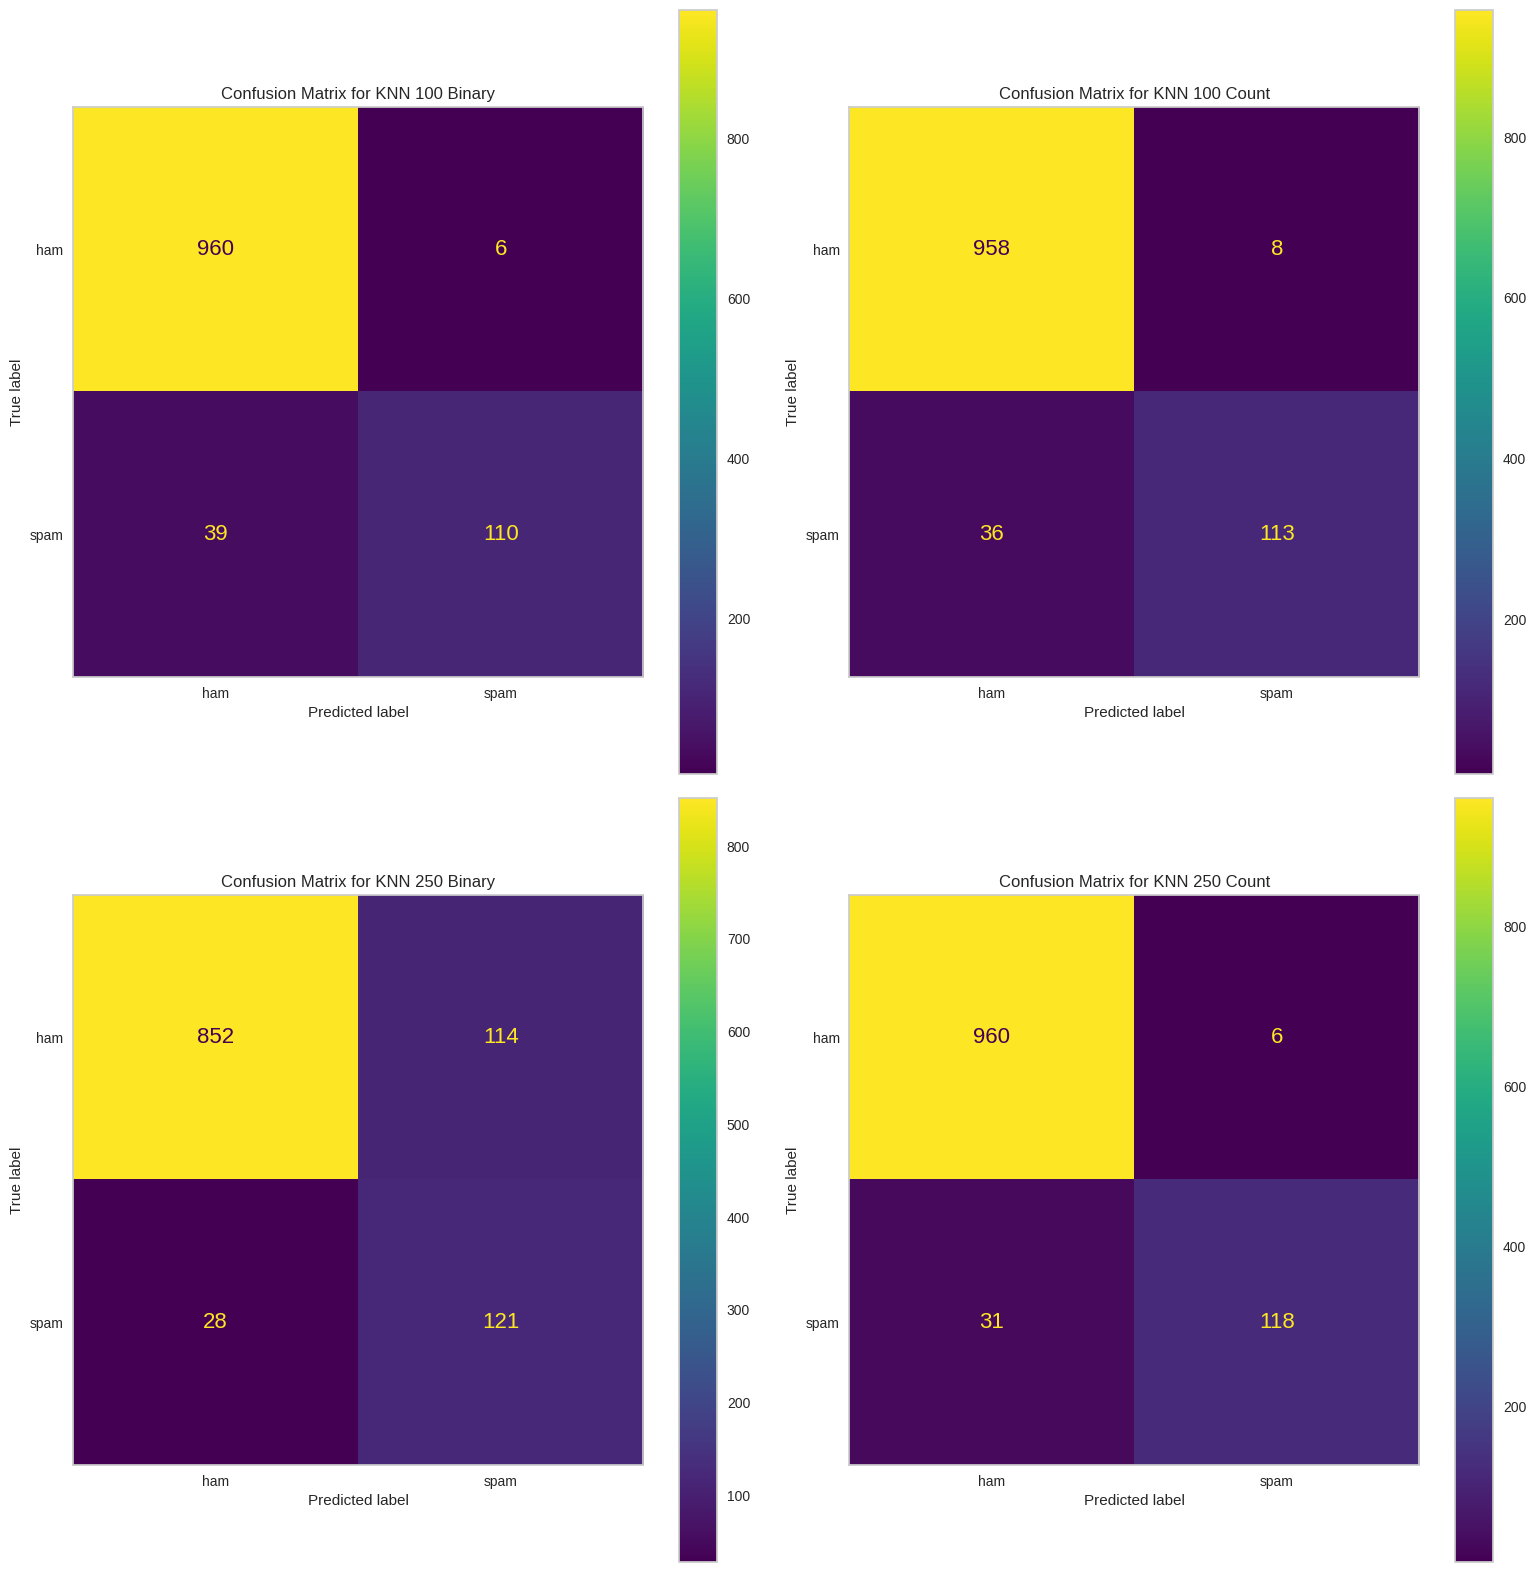

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].grid(False)
axes[0, 1].grid(False)
axes[1, 0].grid(False)
axes[1, 1].grid(False)

ConfusionMatrixDisplay.from_estimator(results_knn['100_B']['best_model'], X_test_100_B, y_test_100_B, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix for KNN 100 Binary')

ConfusionMatrixDisplay.from_estimator(results_knn['100_C']['best_model'], X_test_100_C, y_test_100_C, ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix for KNN 100 Count')

ConfusionMatrixDisplay.from_estimator(results_knn['250_B']['best_model'], X_test_250_B, y_test_250_B, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix for KNN 250 Binary')

ConfusionMatrixDisplay.from_estimator(results_knn['250_C']['best_model'], X_test_250_C, y_test_250_C, ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix for KNN 250 Count')

plt.tight_layout()
plt.show();

Tras aplicar KNN con distintas metricas, distintos numeros de vecinos y los dos tipos de pesos, observamos que ninguno es capaz de mejorar los resultados obtenidos previamente, KNN_250_C es el que obtiene mejores resultados pero no supera con creces al mejor modelo tras aplicar NB ni al mejor modelo tras aplicar LR, a parte de que es el modelo que requiere de un tiempo de computo mayor.

## Evaluación final de los modelos

¿Qué modelo elegirías entre todos? Si nuestro objetivo fuera el poder determinar la clase
de un SMS de la manera más eficiente posible ¿qué modelo te parecería el mejor? No te
limites a escoger uno, piensa en todas las cosas que influyen en el coste de clasificar un
ejemplo.

In [47]:
results_df.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (M),recall score (M),f1 score (M)
Naive Bayes 250 Binary,0.978,0.977,0.925,0.949
Naive Bayes 250 Count,0.974,0.945,0.942,0.944
Logistic Regression 250_B,0.974,0.966,0.920,0.941
Logistic Regression 250_C,0.974,0.966,0.920,0.941
Logistic Regression 100_C,0.969,0.968,0.894,0.926
Logistic Regression 100_B,0.968,0.964,0.893,0.925
KNN 250_C,0.967,0.960,0.893,0.923
Naive Bayes 100 Count,0.963,0.945,0.891,0.915
Naive Bayes 100 Binary,0.962,0.957,0.876,0.911
KNN 100_C,0.961,0.949,0.875,0.907


Vemos que como hemos ido viendo, los mejores resultados que obtenemos son con NB tanto con distribucion Binaria como Multinominal, procedemos ahora a mostrar los mejores resultados obtenidos con cada modelo con la ROC curve.

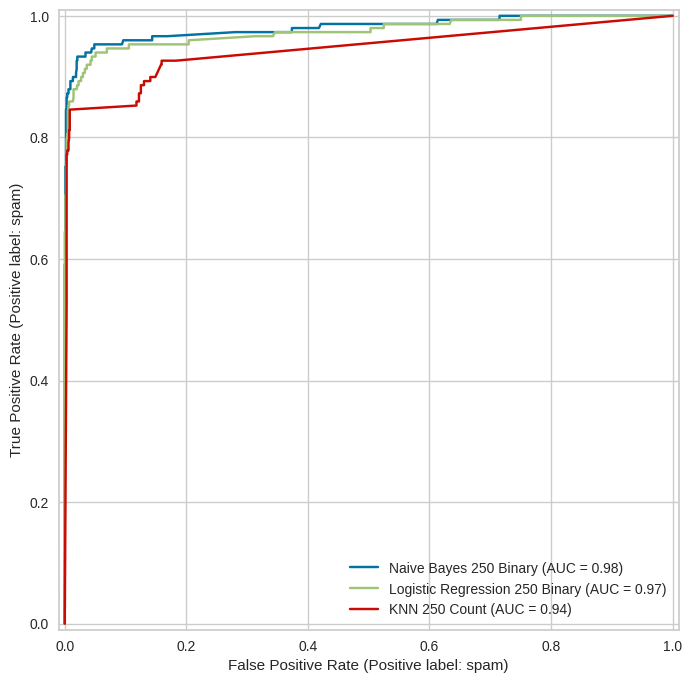

In [48]:
plt.figure(figsize=(8,16));
RocCurveDisplay.from_estimator(nb_250_B, X_test_250_B, y_test_250_B, pos_label='spam', ax=plt.subplot(1, 1, 1), name='Naive Bayes 250 Binary')
RocCurveDisplay.from_estimator(results['250_B']['best_model'], X_test_250_B, y_test_250_B, pos_label='spam', ax=plt.subplot(1, 1, 1), name='Logistic Regression 250 Binary')
RocCurveDisplay.from_estimator(results_knn['250_C']['best_model'], X_test_250_C, y_test_250_C, pos_label='spam', ax=plt.subplot(1, 1, 1), name='KNN 250 Count')

Si comparamos la curva ROC entre los mejores modelos podemos que en la regresión logistica podríamos relajar la prediccion para incluir todos los ejemplos positivos incrementando algo el error, pero en KNN no podemos hacerlo y por lo tanto vemos que KNN obtiene los peores resultados en todos los intervalos y Naive Bayes obtiene los mejores muy cerca de la regresión logística.


### Conclusiones

Tras observar los resultados de todos los modelos para cada conjunto de datos vemos como algunos han obtenido mejores resultados que otros y vemos como tenemos distintos modelos candidatos a ser los mejores.

#### Minimizar el error de la clase **spam**
Dado el problema de clasificación de mensajes SMS como spam o no, si nuestro objetivo es clasificar un SMS como spam con el menor error posible entonces necesitamos un modelo que lo haga muy bien en el recall de la clase spam (nuestra clase minoritaria), por eso debemos elejir el que mejor resultados nos ha dado al predecir los resultados de la clase spam que ha sido el modelo con Naive Bayes con distribucion multinominal con 250 variables, el cual nos da tan solo 15 de 149 falsos positivos en la clase spam (un recall del 90%) es decir de cada 10 SMSs que sean `spam`, 1 lo clasificaremos como `no spam`.


In [49]:
print("Classification Report for 250 Count features:\n", classification_report(y_test_250_C, y_pred_250_C))

Classification Report for 250 Count features:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.98       966
        spam       0.91      0.90      0.90       149

    accuracy                           0.97      1115
   macro avg       0.94      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115



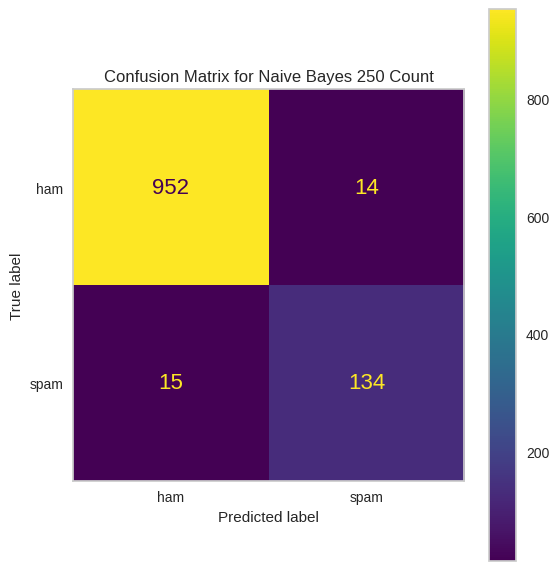

In [50]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.grid(False)
ConfusionMatrixDisplay.from_estimator(nb_250_C, X_test_250_C, y_test_250_C, ax=axes)

plt.title('Confusion Matrix for Naive Bayes 250 Count')
plt.tight_layout()
plt.show();

#### Minimizar el error de la clase **ham**

Ahora bien, si imaginamos que queremos que nuestro modelo sea muy preciso en la clase de los `no spam` sin importarnos demasiado si clasificamos erroneamente los SMSs de `spam`, debemos escojer ese modelo que nos haya dado el recall mas alto en la clase mayoritaria (ham).

Si nos fijamos en todos los resultados el modelo que cumple mejor con ello es el modelo NB con distribucion Bernoulli para 250 columnas dado que solo clasificamos erroneamente 3 de los 963 instancias en la classe mayoritaria

In [51]:
print("Classification Report for 250 Count features:\n", classification_report(y_test_250_B, y_pred_250_B))

Classification Report for 250 Count features:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



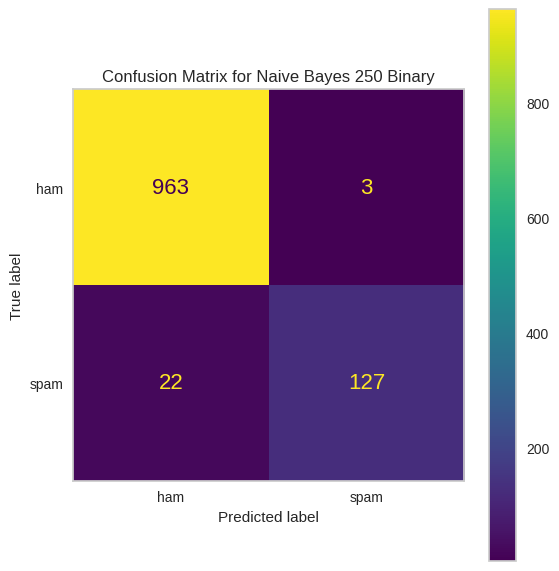

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.grid(False)
ConfusionMatrixDisplay.from_estimator(nb_250_B, X_test_250_B, y_test_250_B, ax=axes)

plt.title('Confusion Matrix for Naive Bayes 250 Binary')
plt.tight_layout()
plt.show();

#### Combinación de clases 

Si quiero quedarme con el modelo con mayor rendimiento balanceado sin tener en cuenta el tamaño de las clases, elejiria el que nos da un resultado mayor de la métrica Macro Average que se encarga precisamente de ello.

Por otra partem, si quiero quedarme con el modelo con un mayor promedio que refleje el tamaño de cada clase pero sin sesgo absoluto hacia la clase mayoritaria, elijiria entonces el que nos de una mayor weighted average.

Para ambos criterios me quedaria tambien con el modelo NB con distribucion Bernoulli para 250 columnas dado que obtengo la mayor f1-score para ambas métricas, 95% y 98% respectivamente.

#### Interpretabilidad
Por otra parte, en muchas ocasiones no solo nos importa poder clasificar bien nuestras instancias.

Hay muchas situaciones en las que se necesita poder interpretar los resultados obtenidos para poder dar feedback e informar de porque el modelo ha tomado una decision u otra y en función de que atributos/parámetros lo ha hecho.

Es por eso que si el la interpretabilidad fuese una exigencia en este problema, escogeria sin duda el conjunto de datos con el que hemos obtenido mejores resultados con regresión logística ya que de los tres modelos, és el único con el que podemos hacer una interpretabilidad de las decisiones tomadas de forma mas comprensible. Por lo tanto eligiria el conjunto de 250 columnas multinominal ya que pese a que tanto el binario como el multinominal nos dan los mismos resultados, el multinominal es capaz de escalar mucho mejor con mas datos.

#### Adaptabilidad

Hay tambien ocasiones y problemas en los que nos gustaria que el modelo no fuese rígido en cuanto a la clasificación y poder modificarlo ligeramente para clasificar un clase u otra.

Es por eso que si en nuestro se nos exigiese esta adaptabilidad, consideraria sin duda usar una regresión logística ya que mirando la ROC curve podria jugar con la distintos parametros para limitar el umbral.

## Conclusiones

- Vemos que KNN no es un modelo que nos haya sido muy util para clasificar sin un SMS es spam o no a parte de que es el que requiere mas tiempo y coste de computación.

- Vemos que la regresión logística nos da resultados bastante buenos pero no tan buenos como Naive Bayes dado que hemos visto con PCA que los resultados no son linealmente separables ni mucho menos

- Vemos que la asunción de que las características son independientes entre sí, lo cual no es del todo realista en textos, en la práctica funciona sorprendentemente bien y por lo tanto NB nos da los mejores resultados.

- Vemos que si quisieramos mejorar nuestros modelos de clasificación, probablemente deberiamos incluir un oversampling de la clase minoritaria dado que el desbalance es muy exagerado y afecta a los modelos a la hora de clasificar sacrificando tiempo de computo

- Vemos como los mejores modelos son siempre aquellos con mas palabras, lo que nos indica que probablemente aumentar el número de columnas que se especifican en el CountVectorizer sería otra forma de obtener mejores resultados lo que implicaria un mayor coste de computacion tambien.

- Para mejorar la clasificación, tal vez podriamos cojer como atributos conjuntos de palabras en lugar de palabras individuales dado que la presencia de distintas palabras en un orden en especifico puede ser un claro distintivo de spam o no spam.
